In [ ]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.evaluator import Evaluator

import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM, Bidirectional, Attention, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))


print("¿GPU disponible?:", tf.config.list_physical_devices('GPU'))

2024-11-05 13:39:49.439074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 13:39:49.450979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 13:39:49.466821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 13:39:49.472520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 13:39:49.482794: I tensorflow/core/platform/cpu_feature_guar

¿GPU disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
I0000 00:00:1730810391.064795    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730810391.093856    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730810391.094040    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

In [2]:
train = Loader.load_NLP()

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [3]:
def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
def filter_train_data(train):
    descriptions = [col for col in train.columns if "description" in col]
    train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
    filtered_columns = ["price", "km", "fuelType", "full_description"]
    train = train[filtered_columns]
    train.dropna(inplace=True)
    return train

train = filter_train_data(train)

km_scaler = StandardScaler()
train["km"] = km_scaler.fit_transform(train["km"].to_numpy().reshape(-1, 1))

price_scaler = StandardScaler()
train["price"] = price_scaler.fit_transform(train["price"].to_numpy().reshape(-1, 1))

/tmp/ipykernel_4943/2940014903.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [4]:
#Parameters
verb_size = 150

In [5]:
# Load data (assuming df is your DataFrame containing the required columns)
texts = train['full_description'].values  # descriptions
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=verb_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences,  maxlen=verb_size, padding='post')

In [6]:
train_data, test_data, train_prices, test_prices, train_km, test_km = train_test_split(
    data, train['price'], train['km'], test_size=0.2, random_state=42, stratify=train['fuelType'])

In [7]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.int32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.int32)

I0000 00:00:1730810460.701078    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730810460.701292    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730810460.701389    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730810460.752214    4943 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
train_prices = tf.convert_to_tensor(train_prices, dtype=tf.float32)
test_prices = tf.convert_to_tensor(test_prices, dtype=tf.float32)

In [9]:
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)

In [10]:
# Text input branch
text_input = Input(shape=(train_data.shape[1],), dtype='int32')

# Capa de Embedding
text_embed_layer = Embedding(input_dim=train_data.shape[1], output_dim=verb_size, input_length=train_data.shape[1])
text_embed = text_embed_layer(text_input)

# Primera capa LSTM bidireccional con 'return_sequences=True' para permitir apilar más capas
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(text_embed)
lstm_out = Dropout(0.5)(lstm_out)

# Segunda capa LSTM
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# Capa de Atención
attention_out = Attention()([lstm_out, lstm_out])

# Aplanamos la salida de la atención
flatten = Flatten()(attention_out)

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Embedding input branch

# KM branch
input_km = Input(shape=(1,), name='km_input')
km_processed = Dense(32, activation='linear')(input_km)

# Concatenate both branches
concat = Concatenate()([flatten, km_processed])
hidden = Dense(256, activation='relu')(concat)
output = Dense(1, activation='linear')(hidden)  # Output layer for price prediction

model = Model(inputs=[text_input, input_km], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 150)  │     22,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 150, 256)  │    285,696 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 150, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 150, 64)   │     82,176 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 150, 64)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 150, 64)   │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9600)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9632)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,466,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,856,741 (10.90 MB)

 Trainable params: 2,856,741 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='huber', metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [13]:
# Train the model
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit([train_data, train_km], train_prices,
          validation_data=([test_data, test_km], test_prices),
          epochs=60, batch_size=128)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/60


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-11-05 13:41:04.251331: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1127 - mean_absolute_error: 0.3116 - mean_absolute_percentage_error: 182.7514

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - loss: 0.1127 - mean_absolute_error: 0.3116 - mean_absolute_percentage_error: 182.7330 - val_loss: 0.0679 - val_mean_absolute_error: 0.2280 - val_mean_absolute_percentage_error: 133.6556
Epoch 2/60
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - loss: 0.0685 - mean_absolute_error: 0.2329 - mean_absolute_percentage_error: 129.7154 - val_loss: 0.0612 - val_mean_absolute_error: 0.2144 - val_mean_absolute_percentage_error: 116.9652
Epoch 3/60
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - loss: 0.0599 - mean_absolute_error: 0.2149 - mean_absolute_percentage_error: 124.3726 - val_loss: 0.0591 - val_mean_absolute_error: 0.2130 - val_mean_absolute_percentage_error: 114.4257
Epoch 4/60
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - loss: 0.0555 - mean_absolute_error: 0.2051 - mean_absolute_percentage_error: 137.0377 - val_loss: 0.0452 - val_mean_absolute_error: 0.1808 - val_mean_absolute_percentage_error: 108.8471
Epoch 5/60
1033/1033 ━━━━━━━━━━━━━━

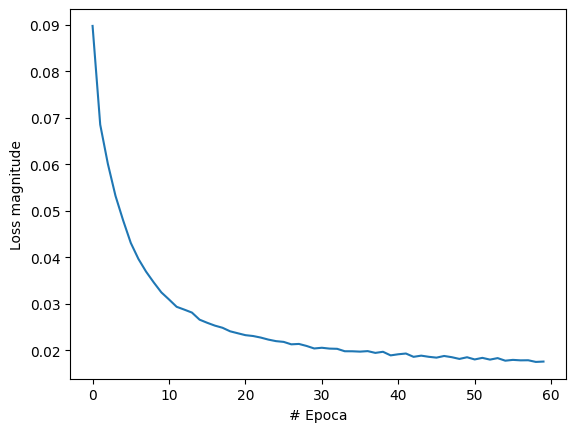

In [14]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [ ]:
predicted_prices = model.predict([test_data, test_km])

# Assuming test_prices is a 1D array, we can convert it to a DataFrame
results_df = pd.DataFrame({
    'Actual_Price': price_scaler.inverse_transform(np.array(test_prices).reshape(-1,1)).flatten(),
    'Predicted_Price': price_scaler.inverse_transform(predicted_prices).flatten(),  # Flatten in case it's a 2D array
    'km' : km_scaler.inverse_transform(test_km.to_numpy().reshape(-1, 1)).flatten()
})

# Display the first few rows of the DataFrame
print(results_df.head())

Evaluator.regression_error_distribution(results_df["Predicted_Price"], results_df["Actual_Price"], plot=False, bins=10)

   1/1033 ━━━━━━━━━━━━━━━━━━━━ 3:16 190ms/step

/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
   Actual_Price  Predicted_Price        km
0  35000.000000     28825.933594  120145.0
1  14400.000000     16495.812500   48873.0
2  27590.000000     31320.207031   60000.0
3  22500.000000     22872.984375      14.0
4   8300.000977     10440.633789  193123.0
MAE: 2672.0876 
 MSE: 32163442.0 
 RMSE: 5671.282 
 R2: 0.9297767877578735 
 MAPE: 14.120347797870636
Mean: 2672.0876
Variance: 25023392.0
Standard Deviation: 5002.339
{'(-0.0051, 646.61]': 6606, '(646.61, 1336.42]': 6605, '(1336.42, 2186.72]': 6606, '(2186.72, 3605.91]': 6605, '(3605.91, 294757.56]': 6606}
